### Basic usage of the `Hypersolver` API

We showcase the `torchdyn` API for [hypersolvers](https://arxiv.org/pdf/2007.09601.pdf). Hypersolvers, or hybrid ODE solvers equipped with a neural network to approximate residuals, are seamlessly integrated into the `odeint` API. A major design of the API is exactly preserving a persistent state for the solver, which in the case of standard ODE solvers contains the Tableau. For hypersolvers, the state also contains their hypernetwork parameters.

In [59]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
class Lorenz(nn.Module):
    def __init__(self):
        super().__init__()
        self.p = nn.Linear(1,1)
    
    def forward(self, t, x):
        x1, x2, x3 = x[...,:1], x[...,1:2], x[...,2:]
        dx1 = 10 * (x2 - x1)
        dx2 = x1 * (28 - x3) - x2
        dx3 = x1 * x2 - 8/3 * x3
        return torch.cat([dx1, dx2, dx3], -1)

In [136]:
x0 = torch.randn(512, 3) + 15 # solve 512 IVPs in parallel!
t_span = torch.linspace(0, 5, 4000)
sys = Lorenz()
t_eval, sol_gt = odeint(sys, x0, t_span, solver='tsit5', atol=1e-8, rtol=1e-8)

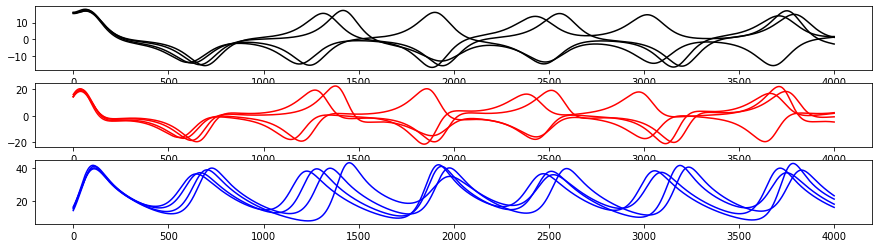

In [137]:
fig = plt.figure(figsize=(15, 4))
axs = fig.subplots(3,1)
axs[0].plot(sol_gt[:,:4,0], c='black'); axs[1].plot(sol_gt[:,:4,1], c='r'); axs[2].plot(sol_gt[:,:4,2], c='b');

#### Can we speed up simulation?

In [138]:
class VanillaHyperNet(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
        for p in self.net.parameters():
            torch.nn.init.uniform_(p, 0, 1e-5)
    def forward(self, t, x):
        return self.net(x)

In [139]:
net = nn.Sequential(nn.Linear(3, 64), nn.Softplus(), nn.Linear(64, 64), nn.Softplus(), nn.Linear(64, 3))
hypersolver = HyperEuler(VanillaHyperNet(net))
t_eval, sol = odeint(sys, x0, t_span, solver=hypersolver, atol=1e-5, rtol=1e-5)
sol = sol.detach()

Text(0.5, 1.0, 'Error on $x_2$')

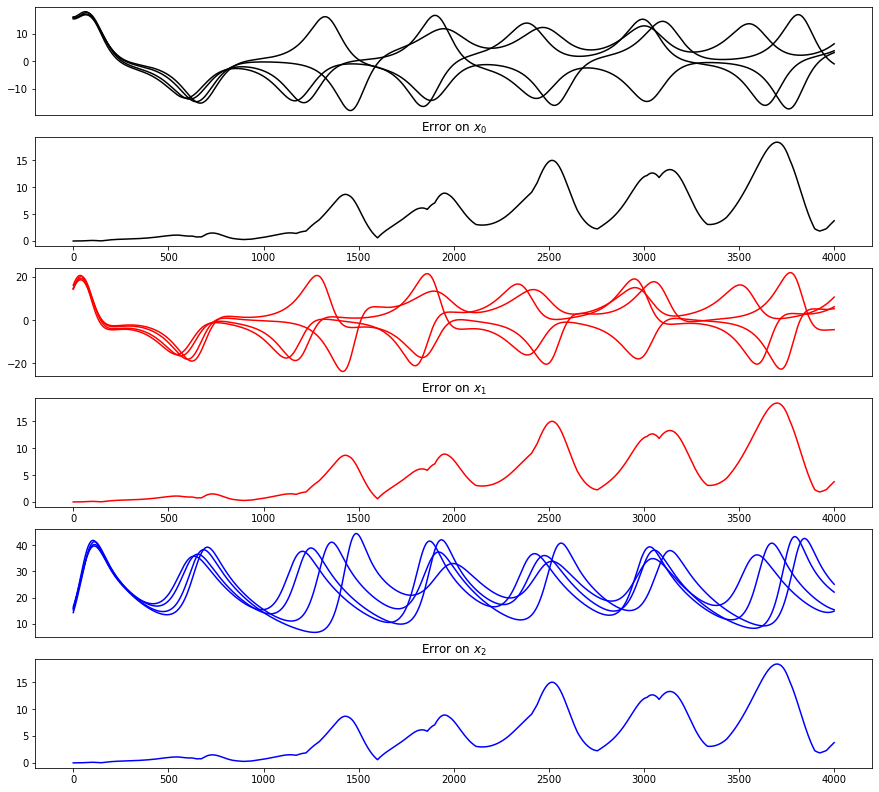

In [152]:
fig = plt.figure(figsize=(15, 14))
axs = fig.subplots(6,1)
axs[0].plot(sol[:,:4,0], c='black'); axs[2].plot(sol[:,:4,1], c='r'); axs[4].plot(sol[:,:4,2], c='b');
axs[0].set_xticks([]); axs[2].set_xticks([]); axs[4].set_xticks([])
# The error accumulates as Euler (base solver of HyperEuler) does not converge here. 
# Here we plot the errors (mean across batches of initial conditions)
axs[1].plot((sol-sol_gt)[:,:4,0].abs().mean(1), c='black')
axs[1].set_title('Error on $x_0$')
axs[3].plot((sol-sol_gt)[:,:4,0].abs().mean(1), c='r')
axs[3].set_title('Error on $x_1$')
axs[5].plot((sol-sol_gt)[:,:4,0].abs().mean(1), c='b');
axs[5].set_title('Error on $x_2$')

#### Train the Hypersolver

We can train our hypersolver on residuals between ground-truth solution and base solver (in this case Euler)

In [78]:
base_solver = Euler()
X = sol_gt[:-1].reshape(-1, 3)
X_next_gt = sol_gt[1:].reshape(-1, 3)
# step forward (fixed-step, time-invariant system hence any `t` as first argument is fine) with base solver
dt = t_span[1] - t_span[0]
_, _, X_next = base_solver.step(sys, X, 0., dt) # step returns a Tuple (k1, berr, sol). The first two values are used internally
# within `odeint`
residuals = (X_next_gt - X_next) / dt**2

In [79]:
device = torch.device('cuda:0')
model = nn.DataParallel(hypersolver, device_ids=[0,1]) # feel free to change here according to your setup and GPU available.
model = model.to(device)
X = X.to(device)
residuals = residuals.to(device)

In [80]:
# training will take a while...
opt = torch.optim.Adadelta(model.parameters(), lr=3e-4)
STEPS = 300000
loss_func = nn.MSELoss()
hypernet = model.module.hypernet
for k in range(STEPS):
    residuals_hypersolver = hypernet(0., X)
    loss = loss_func(residuals, residuals_hypersolver)
    print(f'Step: {k}, Residual loss: {loss:.3f}', end='\r')
    loss.backward(); opt.step(); opt.zero_grad()

In [123]:
# roughly twice as fast as a rk4 (3 orders higher). How does the accuracy compare to the base solver (and others)?
# sampling different initial conditions (off distribution to test generalization)
x0 = torch.randn(5, 3) + 14 # solve 5 IVPs in parallel!

hypersolver = hypersolver.to(device)
x0 = x0.to(device)

t0 = time.time()
t_eval, sol = odeint(sys, x0, t_span, solver=hypersolver)
sol = sol.detach().cpu()
hyper_sol_time = time.time() - t0

t0 = time.time()
t_eval, base_sol = odeint(sys, x0, t_span, solver='euler')
base_sol = base_sol.detach().cpu()
base_sol_time = time.time() - t0

t0 = time.time()
t_eval, rk4_sol = odeint(sys, x0, t_span, solver='rk4')
rk4_sol = rk4_sol.detach().cpu()
rk4_sol_time = time.time() - t0

t0 = time.time()
t_eval, dp5_low_sol = odeint(sys, x0, t_span, solver='dopri5', atol=1e-3, rtol=1e-3)
dp5_low_sol = dp5_low_sol.detach().cpu()
dp5_low_time = time.time() - t0

In [124]:
t_eval, sol_gt = odeint(sys, x0, t_span, solver='tsit5', atol=1e-6, rtol=1e-6)
sol_gt = sol_gt.detach().cpu()

In [125]:
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

Text(0.5, 1.0, 'Wall-clock sol time')

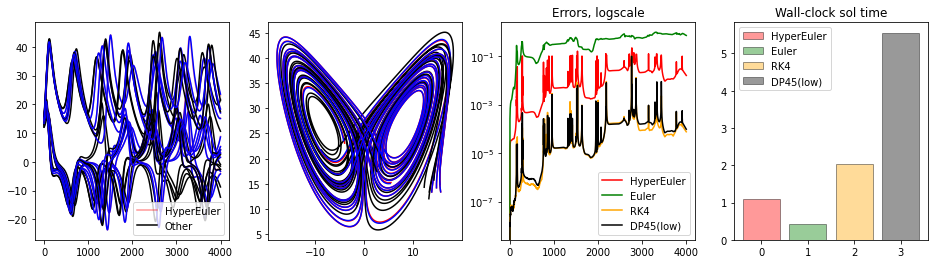

In [133]:
error_hyper = smape(sol_gt, sol).mean(1).sum(1)
error_base = smape(sol_gt, base_sol).mean(1).sum(1)
error_rk4 = smape(sol_gt, rk4_sol).mean(1).sum(1)
error_dp5 = smape(sol_gt, dp5_low_sol).mean(1).sum(1)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,4,1)
for i in range(4):
    for j in range(3):
        ax.plot(sol[:,i,j], c='r', alpha=0.4)
        ax.plot(sol_other[:,i,j], c='black')
        ax.plot(sol_gt[:,i,j], c='blue')
        ax.legend(['HyperEuler', 'Other'])
        
ax = fig.add_subplot(1,4,2)
for i in range(4):
    ax.plot(sol[:,i,0], sol[:,i,2], c='r')
    ax.plot(sol_other[:,i,0], sol_other[:,i,2], c='black')
    ax.plot(sol_gt[:,i,0], sol_gt[:,i,2], c='blue')


ax = fig.add_subplot(1,4,3)
ax.plot(error_hyper, c='r')
ax.plot(error_base, c='green')
ax.plot(error_rk4, c='orange')
ax.plot(error_dp5, c='black')
ax.set_yscale('log')
ax.legend(['HyperEuler', 'Euler', 'RK4', 'DP45(low)'])
ax.set_title('Errors, logscale')


times = [hyper_sol_time, base_sol_time, rk4_sol_time, dp5_low_time]
ax = fig.add_subplot(1,4,4)
colors = ['r', 'g', 'orange', 'black']
for k in range(4):
    barlist = ax.bar(0 + k, times[k:k+1], color=colors[k], alpha=0.4, edgecolor='black')
ax.legend(['HyperEuler', 'Euler', 'RK4', 'DP45(low)'])
ax.set_title('Wall-clock sol time')

Great!  (try to resume training to further improve accuracy of HyperEuler)

For the curious, here are more applications of [hypersolvers to Neural ODEs](https://github.com/DiffEqML/diffeqml-research/tree/master/hypersolver). For those interested in hypersolvers usage for non-neural ODEs, here is further analysis specifically centered around [HyperEuler](https://arxiv.org/abs/2003.09573#:~:text=In%20this%20paper%2C%20we%20propose,with%20a%20large%20step%20size.) (or DeepEuler). Note: we have other hypersolvers in `torchdyn`! The API also allows you to quickly wrap a given solver to turn it into its hyper-variant, see `torchdyn.numerics.hypersolvers.py`.

For more applications of hypersolvers, check out the optimal control tutorial in module 3.